In [1]:
import sys
sys.path.insert(0, '/Users/mattlowery/Desktop/Desko/code/astro/hetvae/src/')
import utils

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
%load_ext autoreload
%autoreload

In [4]:
lcs = utils.get_data(folder='../datasets/ZTFgr_small', start_col=1, min_length=40, shuffle=False)

validated 1483 files out of 1483 for band='r'
validated 1484 files out of 1484 for band='g'
1483 1483
created union_tp attribute of length 3500
dataset created w/ shape (1043, 2, 1639, 3)
train size: 938, valid size: 94, test size: 105


In [21]:
def preview_lcs(lcs, bands, batch_num = 0, N=1, figsize=(15,15)):
    """
    preview some of the loaded light curves
    
    parameters:
        dataloader
        bands      (list)   --> list of bands for labeling the plots
        
        ----- optional -----
        batch_num  (int)    0        --> which batch you want to plot 
        N          (int)    1        --> number of object's light curves to plot
        figsize    (tuple)  (15,15)  --> size of the plotting
    """
    dims = lcs.dataset.shape[1]
    fig, ax = plt.subplots(N, dims, figsize=figsize, squeeze=False)
  
    for i in range(N):
        obj_name = lcs.valid_files_df.index.values[i]
        print(obj_name, i)
        for band in range(dims):
            t = lcs.dataset[i,band,:,0]
            y = lcs.dataset[i,band,:,1]
            yerr = lcs.dataset[i,band,:,2]
            pts = y.nonzero()[0]
            ax[i][band].errorbar(t[pts],y[pts], yerr=yerr[pts], c='blue', fmt='.', markersize=4, ecolor='red', elinewidth=1, capsize=2)
            ax[i][band].text(0.0, 1.0,i)
    lines_labels = ax[0][0].get_legend_handles_labels()
    lines,labels = lines_labels[0], lines_labels[1]
    fig.legend(lines, labels, bbox_to_anchor=(0.12, 0.92), loc='upper left')
    [ax[i][index].set_xlabel(bands[index]) for index in range(len(bands))]
    

015653.16-004623.2 0
033141.09-061248.0 1
222328.64-090448.8 2
084846.66+120527.2 3
094458.41+591805.5 4
084225.85+532235.1 5
005147.12+061903.5 6
014156.00+023145.0 7
091350.90+083629.1 8
094945.68+632622.8 9
224507.59-023607.1 10
214824.72+055410.8 11
091606.34-012008.0 12
000018.77+191232.9 13
095502.10+553232.2 14
230013.06+195754.6 15
090138.51+583859.2 16
014032.08+255417.9 17
083131.41+223704.2 18
010750.29+191100.3 19
003143.38+193156.9 20
034543.08-051708.9 21
080306.81+195953.1 22
090318.03+035218.3 23
014819.57+032424.9 24
090415.14+493224.1 25
073519.39+430918.1 26
011831.62+073412.7 27
081339.44+550859.6 28
081151.74+440152.1 29
093203.52+605611.3 30
225515.20+182640.0 31
084235.20+392149.7 32
230733.86+095202.9 33
084038.01+124945.2 34
222521.79+044213.4 35
235646.74+013032.5 36
075751.04+150918.6 37
002618.76-035720.5 38
023059.85-055245.7 39
003622.81+304415.8 40
085526.25+385859.9 41
083502.86+473408.0 42
011758.83+002021.4 43
230015.25+183032.7 44
013256.97+193255.7 4

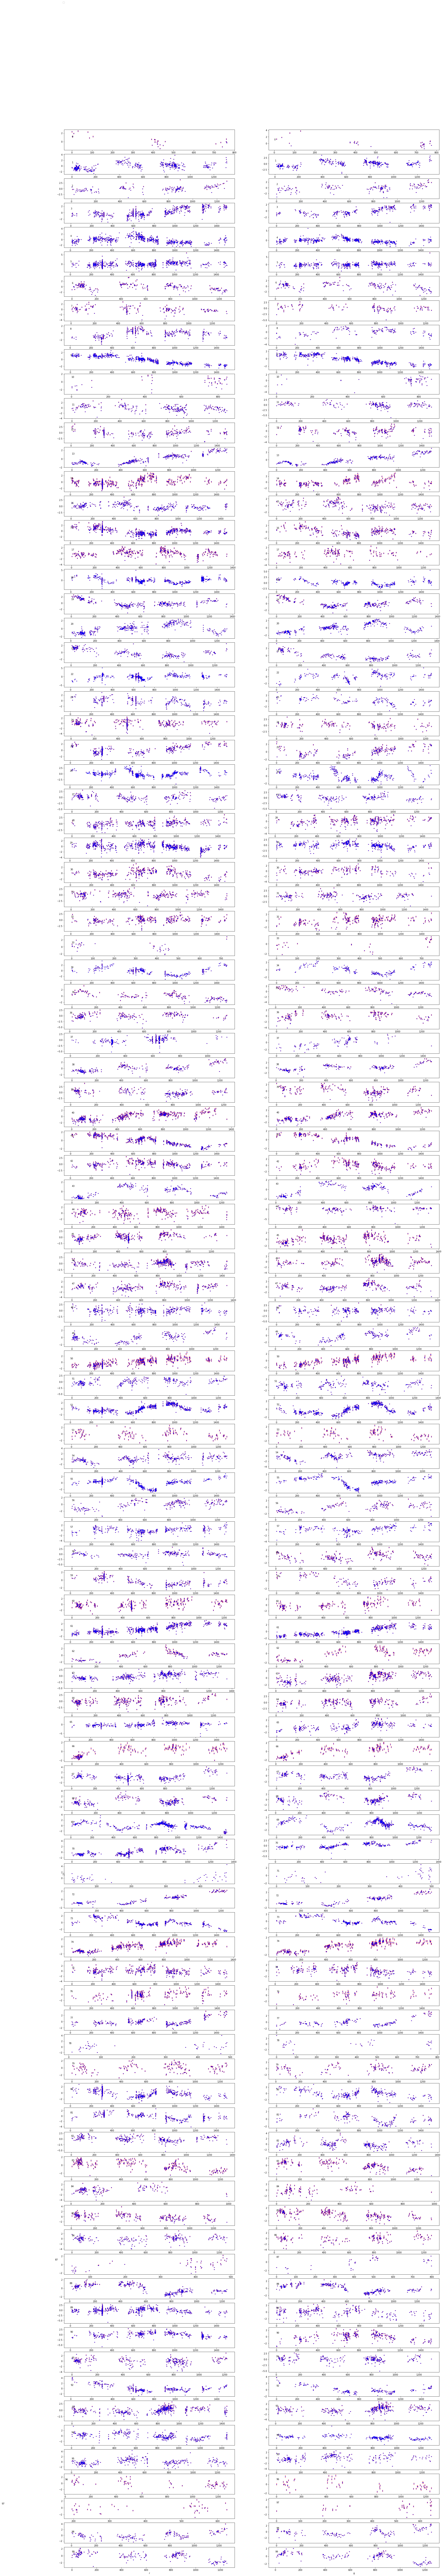

In [22]:
preview_lcs(lcs, bands=lcs.bands, N=100,figsize=[30,200])

In [1]:
plt.plot(utils.frange_cycle_linear(4000, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5))
plt.title('Linear Cyclical KL Annealing Schedule')
plt.xlabel('num iters')
plt.ylabel('kl coef')
plt.savefig('kl_sched')

NameError: name 'plt' is not defined

In [35]:
import pandas as pd


In [33]:
import glob
r,g = glob.glob('../datasets/ZTFgr_small/*/033141.09-061248.0*')

In [78]:
df = pd.read_csv(r, sep=',').to_numpy()

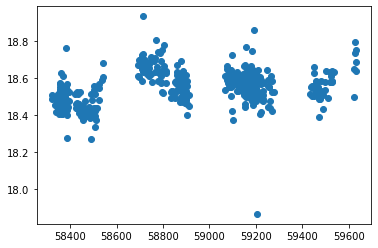

In [84]:
plt.scatter(df[:,1],df[:,2])